In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
from data_reader import read_data
from node import get_node_data
import pandas as pd
import numpy as np

In [3]:
data = read_data()
nodes = {"pi"+str(i+2):i for i in range(4)}

## Visualising Data

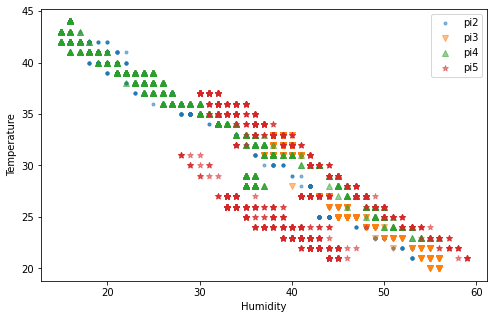

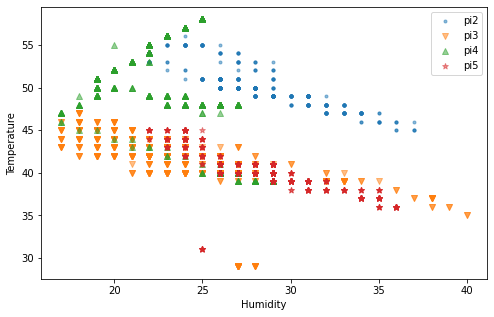

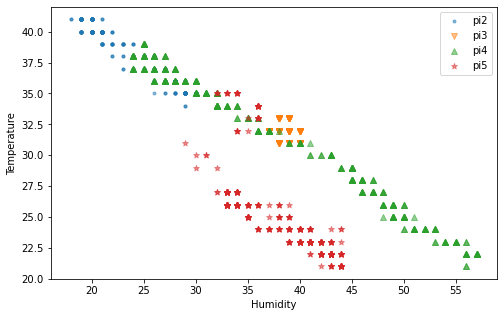

In [4]:
from visualising import visualise_experiments as visualise
visualise(data)

## Similarity MMD

In [16]:
from maximum_mean_discrepancy import MMD, get_tensor_samples
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable

def bandwidth_experiment(samples, similar_sets, dissimilar_sets, bandwidths, kernel):
    print(kernel.upper(), "\n")
    t = PrettyTable(['Bandwidth', 'Similarity MMD', 'Dissimilarity MMD'])
    for bandwidth in bandwidths:
        avg_sim_mmd, avg_dis_mmd, s, d = ASDMMD(samples, similar_sets, dissimilar_sets, kernel, bandwidth)
        t.add_row([bandwidth, avg_sim_mmd, avg_dis_mmd])
        print(s)
        print(d)
        print()
        
    print(t)
    print()

### Experiment 1

Nodes pi2 and pi4 are similar according to mmd and nodes pi3 and pi5 are similar to each other but not to the others

In [26]:
m = 200
samples = get_tensor_samples(data, experiment=1, sample_size=m)

In [6]:
similar_sets = ["pi2","pi4"]
dissimilar_sets = ["pi3","pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi2', 'pi4') | tensor(2.0339) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi3', 'pi2') | tensor(32.9921) |
| ('pi3', 'pi4') | tensor(32.4272) |
| ('pi5', 'pi2') | tensor(27.7680) |
| ('pi5', 'pi4') | tensor(27.0771) |
| ('pi3', 'pi5') |  tensor(3.7611) |
+----------------+-----------------+

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi2', 'pi4') | tensor(6.1016) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi3', 'pi2') | tensor(98.9763) |
| ('pi3', 'pi4') | tensor(97.2816) |
| ('pi5', 'pi2') | tensor(83.3041) |
| ('pi5', 'pi4') | tensor(81.2314) |
| ('pi3', 'pi5') | tensor(11.2832) |
+

similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1, 10, 5), "rbf")

### Experiment 3

Nodes pi3, pi4, pi5 are dissimilar with pi2. Nodes pi3 and pi4 are similar to each other and similar to pi5.

In [35]:
samples = get_tensor_samples(data, experiment=3, sample_size=m)

In [36]:
similar_sets = ["pi2", "pi4"]
dissimilar_sets = ["pi3", "pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

LINEAR 

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi4') | tensor(30.2673) |
| ('pi3', 'pi2') | tensor(28.2074) |
| ('pi3', 'pi4') |  tensor(2.6067) |
| ('pi5', 'pi4') |  tensor(5.7325) |
| ('pi3', 'pi5') |  tensor(7.0070) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi5', 'pi2') | tensor(39.8775) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi2', 'pi4') | tensor(90.8019) |
| ('pi3', 'pi2') | tensor(84.6223) |
| ('pi3', 'pi4') |  tensor(7.8203) |
| ('pi5', 'pi4') | tensor(17.1976) |
| ('pi3', 'pi5') | tensor(21.0213) |
+----------------+-----------------+
+----------------+------------------+
|     Nodes      |  Dissimilar MMD  |
+----------------+------------------+
| ('pi5', 'pi2') | tensor

similar_sets = ["pi2", "pi3", "pi4"]
dissimilar_sets = ["pi5"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(1,5 , 4), "rbf")

### Experiment 2

In [45]:
samples = get_tensor_samples(data, experiment=2, sample_size=m)

In [46]:
similar_sets = ["pi3", "pi5"]
dissimilar_sets = ["pi2", "pi4"]
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(0.1, 0.7, 4), "linear")
bandwidth_experiment(samples, similar_sets, dissimilar_sets, np.linspace(5,100 , 5), "rbf")

LINEAR 

+----------------+----------------+
|     Nodes      |  Similar MMD   |
+----------------+----------------+
| ('pi3', 'pi5') | tensor(5.3385) |
+----------------+----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(12.1883) |
| ('pi2', 'pi5') | tensor(12.5109) |
| ('pi4', 'pi3') | tensor(12.6573) |
| ('pi4', 'pi5') | tensor(18.7198) |
| ('pi2', 'pi4') |  tensor(6.0502) |
+----------------+-----------------+

+----------------+-----------------+
|     Nodes      |   Similar MMD   |
+----------------+-----------------+
| ('pi3', 'pi5') | tensor(16.0155) |
+----------------+-----------------+
+----------------+-----------------+
|     Nodes      |  Dissimilar MMD |
+----------------+-----------------+
| ('pi2', 'pi3') | tensor(36.5647) |
| ('pi2', 'pi5') | tensor(37.5326) |
| ('pi4', 'pi3') | tensor(37.9719) |
| ('pi4', 'pi5') | tensor(56.1593) |
| ('pi2', 'pi4') | tensor(18.1506

## Testing Hypothesis

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def standarise_data(train, test):
    
    x = scaler.fit_transform(train)
    y = scaler.transform(test)
    return x, y

def get_model_data(experiment):
    model_data = {}
    node_data = get_node_data(data, experiment)
    
    scaler = StandardScaler()
    scaler.fit(pd.concat(node_data).values.astype(np.float32))
    
    for i in range(4):
        node = "pi"+str(i+2)
        train, test = train_test_split(node_data[i].values.astype(np.float32))
        model_data[node] = [train, test]
        model_data[node+"std"] = [scaler.transform(train), scaler.transform(test)]
        
    return model_data

In [5]:
from modelling import fit_clf, score_clf
from prettytable import PrettyTable

def test_in_pairs(similar_sets, model_data, models):
    t = PrettyTable(['Model Node', 'Test Node', 'Model Node R', 'Test Node R'])
    for pair in similar_sets:
        x, x_test = model_data[pair[0]]
        y, y_test = model_data[pair[1]]
        model_x, model_y = models[pair[0]], models[pair[1]]

        baseline_score = fit_clf(model_x, x, x_test)
        test_score = score_clf(model_x, y_test)
        t.add_row([pair[0], pair[1], baseline_score, test_score])

        baseline_score = fit_clf(model_y, y, y_test)
        test_score = score_clf(model_y, x_test)        
        t.add_row([pair[1], pair[0], baseline_score, test_score])
    print(t)

In [11]:
from maximum_mean_discrepancy import get_tensor_samples, find_similar_pairs
from maximum_mean_discrepancy import avg_similarity_disimilarity_MMD as ASDMMD
from prettytable import PrettyTable
from node import get_similar_other_nodes_sets
from modelling import grid_search_models

svr_param_grid = {"kernel": ["rbf", "linear"],
                 "C" : [0.05, 0.1, 0.5, 1, 2, 5, 10, 50],
                 "epsilon" : [0.05, 0.1, 0.15, 0.2, 0.5, 1]
                }

linear_regression_param_grid = {}

def test_hypothesis(experiment, clf_name, kernel, kernel_bandwidth):
    similar_nodes, other_nodes = get_similar_other_nodes_sets(experiment)
    model_data = get_model_data(experiment)
#     data_samples = get_tensor_samples(data, experiment, sample_size=200, standardised = True)
    data_samples = get_tensor_samples(data, experiment, sample_size=200, standardised = False)
    
    asmmd = ASDMMD(data_samples, similar_nodes, other_nodes, kernel, kernel_bandwidth, return_tables = False)
    
#     asmmd = ASDMMD({node:data_samples[node] for node in data_samples.keys() if "std" not in node}, 
#                                                 similar_set, dissimilar_set, 
#                                                 kernel, kernel_bandwidth, 
#                                                 return_tables = False)
    
    similar_pairs, similar_nodes = find_similar_pairs({node:model_data[node] for node in model_data.keys() if "std" not in node},
                                                      asmmd, kernel, kernel_bandwidth)
    
    selected_model_data = {node : model_data[node] for node in similar_nodes}
    
    print("Optimising Models... \n")
    models = grid_search_models(clf_name, selected_model_data, similar_nodes, param_grid = svr_param_grid)
    
    print(f"The average MMD between similar sets is {asmmd} when the data are not standardised")
    print(f"The following sets were deemed similar {similar_nodes} \n")
    test_in_pairs(similar_pairs, selected_model_data, models)
    
# #     asmmd = ASDMMD({node[:-3]:data_samples[node] for node in data_samples.keys() if "std" in node}, 
# #                                                 similar_set, dissimilar_set, 
# #                                                 kernel, kernel_bandwidth, 
# #                                                 return_tables = False)
        
#     model_data = {node[:-3]:model_data[node] for node in model_data.keys() if "std" in node}
    
# #     similar_pairs, similar_nodes = find_similar_pairs(model_data, asmmd, kernel, kernel_bandwidth)
#     selected_model_data = {node : model_data[node] for node in similar_nodes}
#     models = grid_search_models(clf_name, selected_model_data, selected_nodes = similar_nodes, param_grid = svr_param_grid)
    
# #     print(f"The average MMD between similar sets is {avg_similarity} when the data are standardised")
# #     print(f"The following sets were diieemed similar {similar_pairs} \n")
#     test_in_pairs(similar_pairs, selected_model_data, models)

In [ ]:
test_hypothesis(experiment = 2, clf_name = "svr", kernel = "linear", kernel_bandwidth = 0.7)
test_hypothesis(experiment = 2, clf_name = "linear", kernel = "linear", kernel_bandwidth = 0.7)

Optimising Models... 



In [8]:
test_hypothesis(experiment = 1, kernel = "linear", kernel_bandwidth = 0.5)

Optimising Models... 

+------+----------------+-------------------------------------------+------------------------+--------------------+
| Node | Baseline Model | Baseline Coefficient of Determination (R) |    Optimised Model     | Optimised Model R  |
+------+----------------+-------------------------------------------+------------------------+--------------------+
| pi2  |     SVR()      |             0.9913832249705917            | SVR(C=50, epsilon=0.2) | 0.9923346800022971 |
| pi4  |     SVR()      |             0.938636411973026             |  SVR(C=50, epsilon=1)  | 0.9473630455033397 |
+------+----------------+-------------------------------------------+------------------------+--------------------+
The average MMD between similar sets is 10.350341796875 when the data are not standardised
The following sets were deemed similar ['pi2', 'pi4'] 

+------------+-----------+--------------------+--------------------+
| Model Node | Test Node |    Model Node R    |    Test Node R   

In [9]:
test_hypothesis(experiment = 3, kernel = "linear", kernel_bandwidth = 0.5)

Optimising Models... 

+------+----------------+-------------------------------------------+-----------------------+----------------------+
| Node | Baseline Model | Baseline Coefficient of Determination (R) |    Optimised Model    |  Optimised Model R   |
+------+----------------+-------------------------------------------+-----------------------+----------------------+
| pi3  |     SVR()      |            -0.07964802242303182           | SVR(C=0.1, epsilon=1) | -0.10000472065443677 |
| pi4  |     SVR()      |             0.9892478935321716            |  SVR(C=50, epsilon=1) |  0.9909187003850856  |
+------+----------------+-------------------------------------------+-----------------------+----------------------+
The average MMD between similar sets is 24.06243896484375 when the data are not standardised
The following sets were deemed similar ['pi3', 'pi4'] 

+------------+-----------+----------------------+------------------------+
| Model Node | Test Node |     Model Node R     |  